## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Step 1: Compute the camera calibration using chessboard images

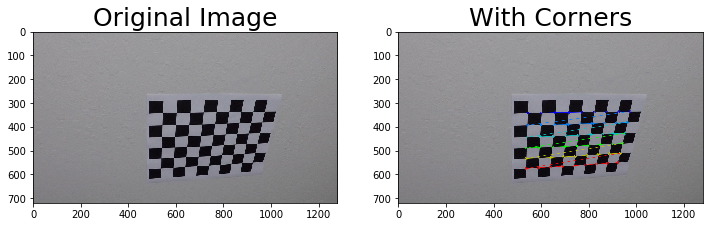

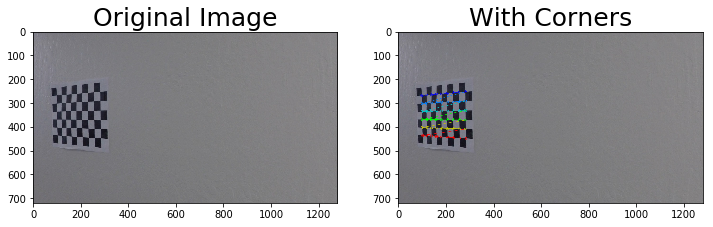

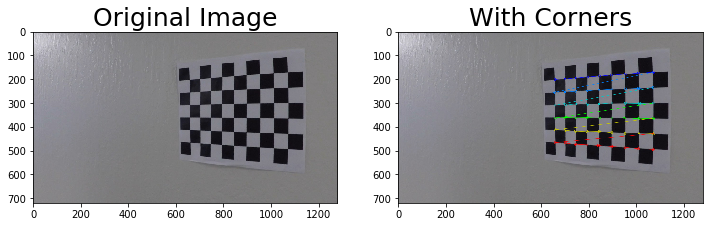

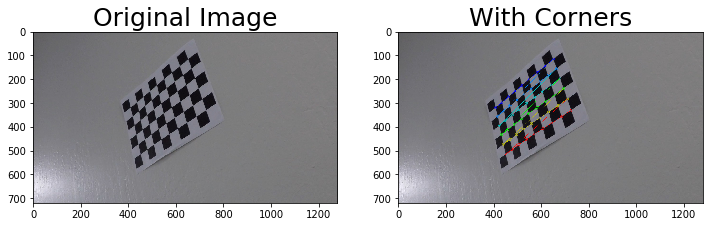

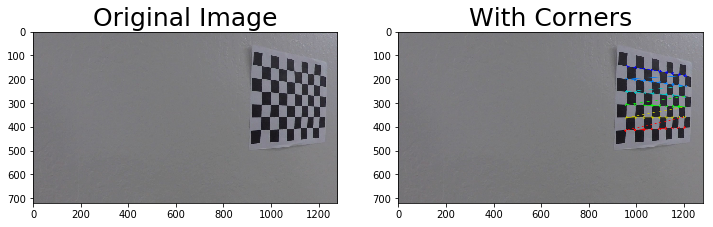

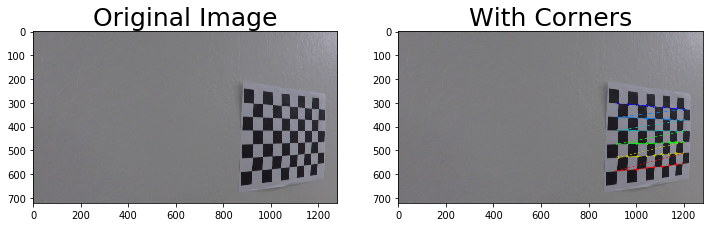

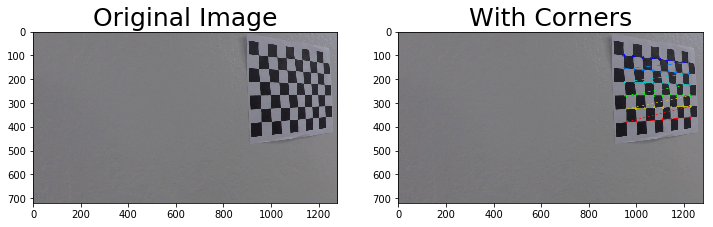

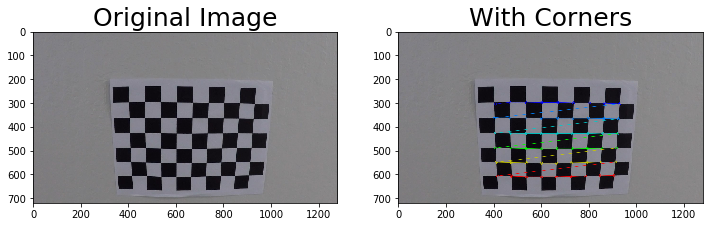

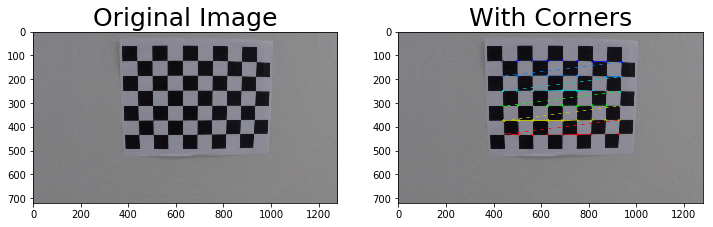

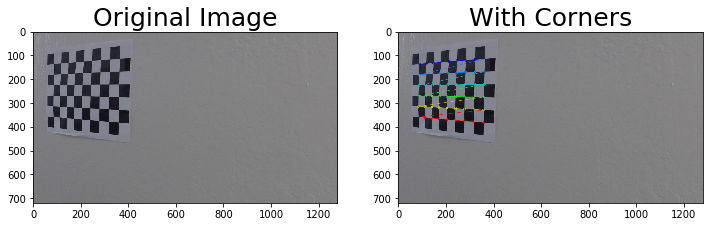

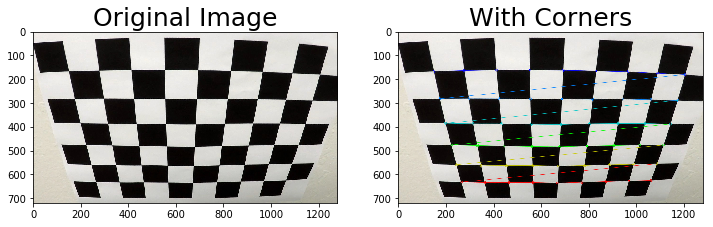

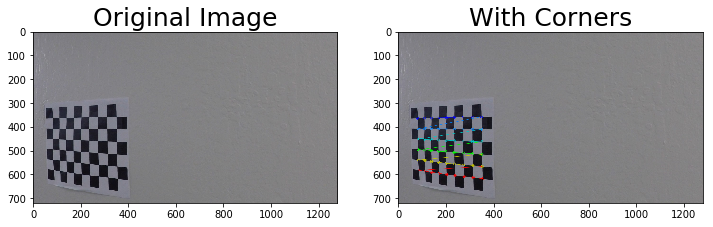

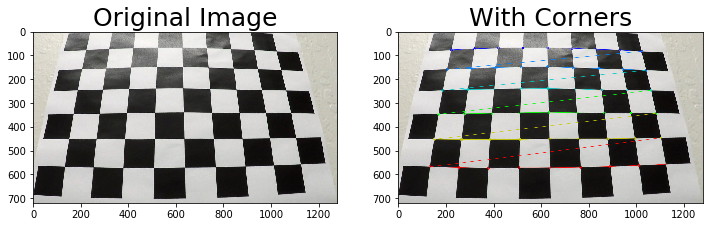

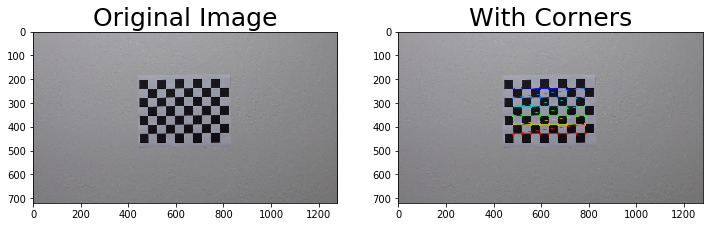

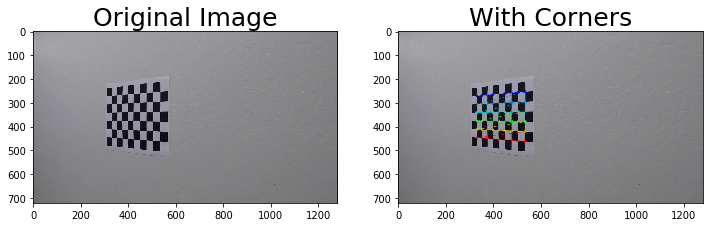

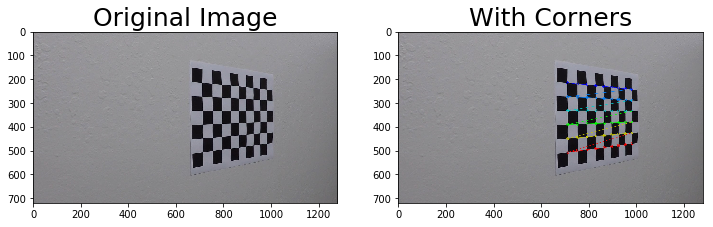

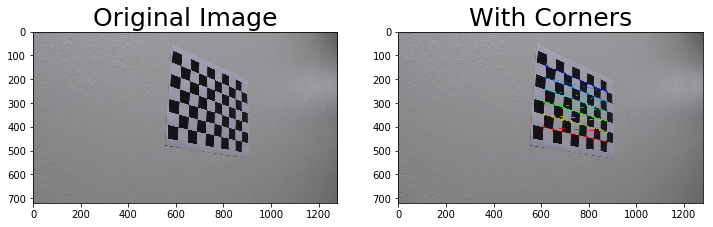

In [6]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
#objp = np.array([objp])

image_count = 0

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for frame in images:
    #img = cv2.imread(fname)
    img = mpimg.imread(frame)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    gray_shape = gray.shape[::-1]
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    # If found, add object points, image points
    if ret == True:
        #corners = np.array([[corner for [corner] in corners]])
        #print(image_count, len(corners))
        
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        
        image_count +=1
        
        # Plot the result
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        #f.tight_layout()
        ax1.imshow(mpimg.imread(frame))
        ax1.set_title('Original Image', fontsize=25)
        ax2.imshow(img)
        ax2.set_title('With Corners', fontsize=25)
        #plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        
        plt.show()

## Step 2: Apply the distortion correction to RAW images

In [7]:
#img = mpimg.imread('../test_images/straight_lines1.jpg')
#img = mpimg.imread('../test_images/straight_lines2.jpg')

# Make a list of test images
images = glob.glob('../test_images/test*.jpg')

In [8]:
def undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undist_img

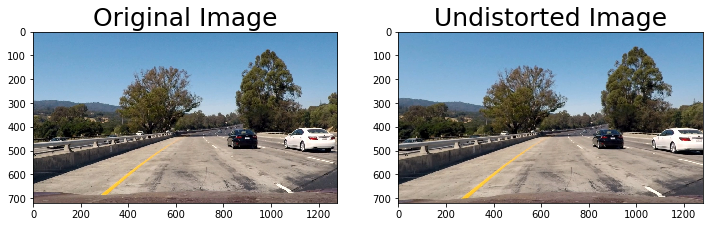

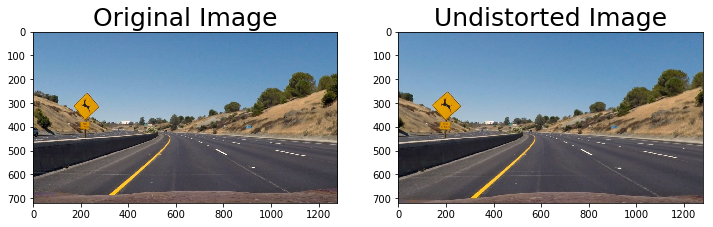

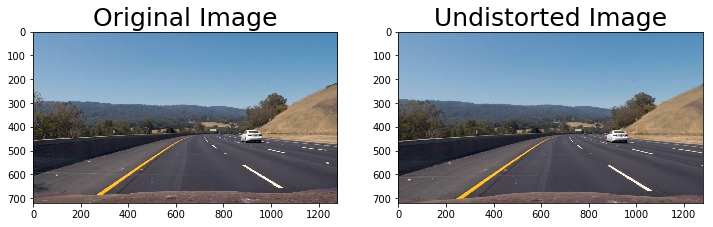

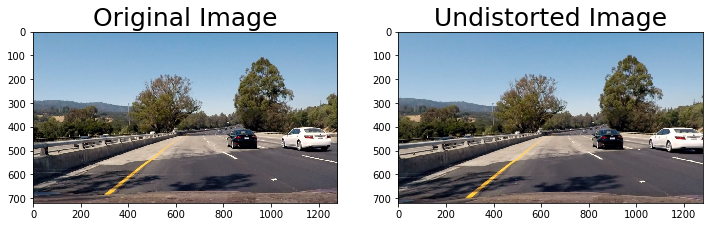

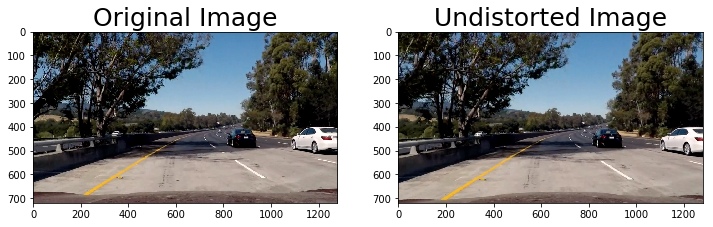

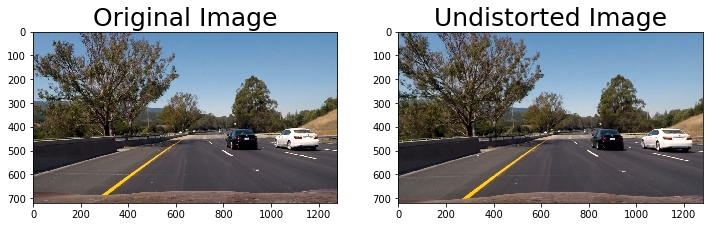

In [9]:
for image in images:
    img = mpimg.imread(image)
    #img = cv2.imread(image)
    undist_img = undistort(img, objpoints, imgpoints)

    # Plot the results
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=25)
    ax2.imshow(undist_img)
    ax2.set_title('Undistorted Image', fontsize=25)

    plt.show()

## Step 3: Apply a perspective transform to rectify binary image ("birds-eye view")

In [10]:
def image_warp(img, src, dst):
    # Convert to grayscale
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped_img = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped_img, M
    

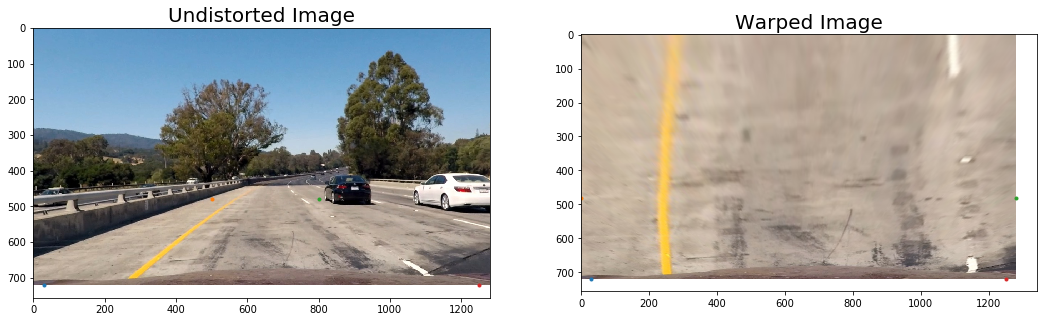

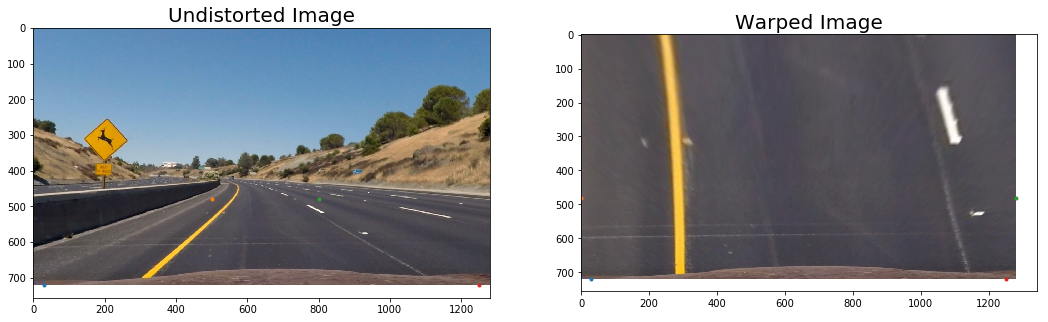

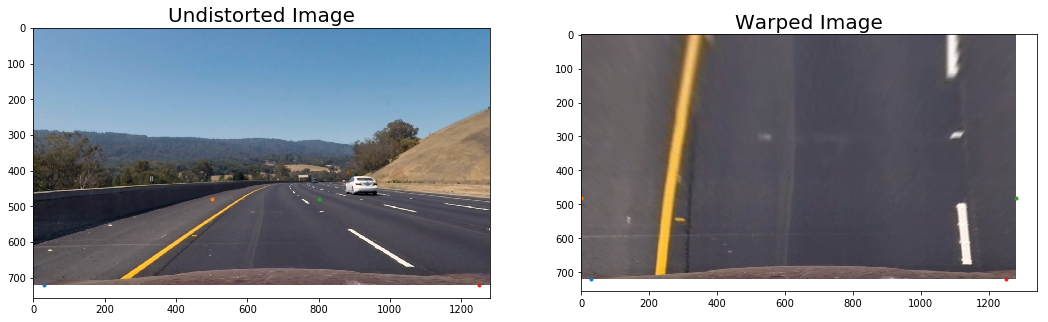

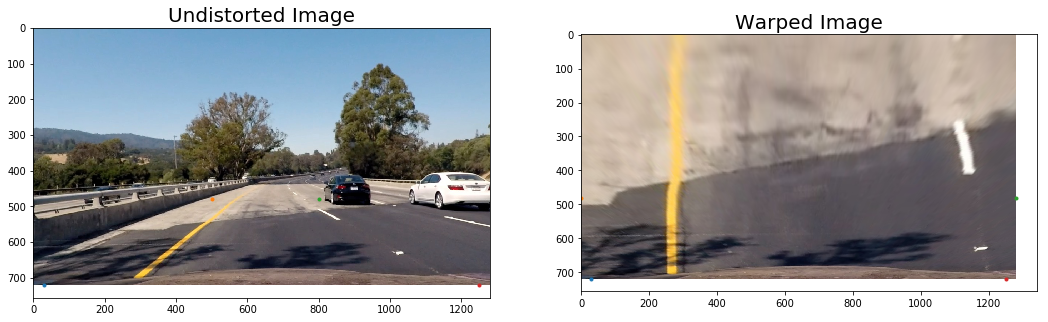

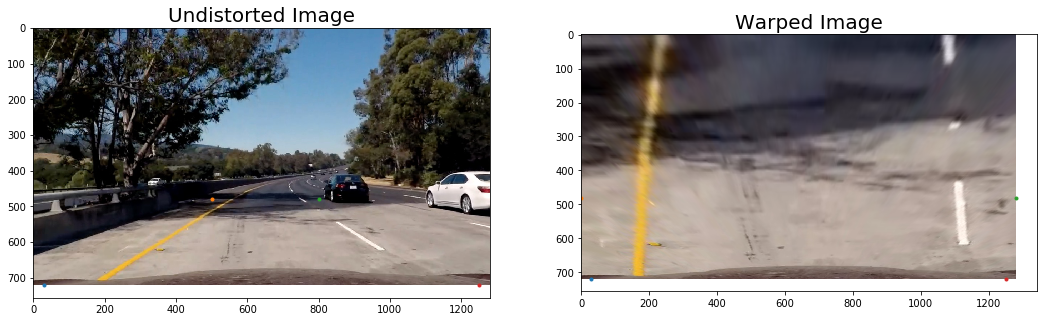

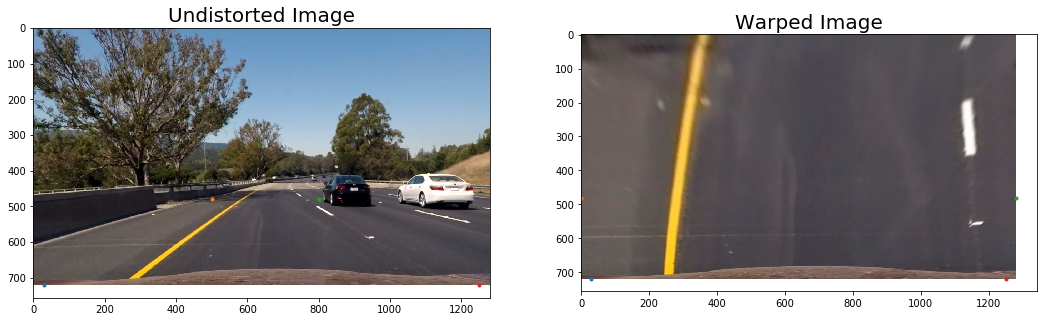

In [11]:
images = glob.glob('../test_images/test*.jpg')
#images = glob.glob('../test_images/straight_lines*.jpg')

#src = np.float32([[40,720], [490,482], [810,482], [1250,720]])
#dst = np.float32([[40,720], [0,0], [1280,0], [1250,720]])

src = np.float32([[30,720], [500,480], [800,480], [1250,720]])
dst = np.float32([[30,720], [0,0], [1280,0], [1250,720]])

for image in images:
    img = mpimg.imread(image)
    undist_img = undistort(img, objpoints, imgpoints)
    
    top_down, perspective_M = image_warp(undist_img, src, dst)
    
    # Plot the results
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    ax1.imshow(undist_img)
    ax1.set_title('Undistorted Image', fontsize=20)
    ax1.plot(src[0][0], src[0][1], '.')
    ax1.plot(src[1][0], src[1][1], '.')
    ax1.plot(src[2][0], src[2][1], '.')
    ax1.plot(src[3][0], src[3][1], '.')
    ax2.imshow(top_down)
    ax2.set_title('Warped Image', fontsize=20)
    ax2.plot(dst[0][0], src[0][1], '.')
    ax2.plot(dst[1][0], src[1][1], '.')
    ax2.plot(dst[2][0], src[2][1], '.')
    ax2.plot(dst[3][0], src[3][1], '.')
    
    plt.show()

## Step 4: Thresholding images with color transforms and gradients

In [12]:
# Apply HLS color space
def hls_select(img, thresh=(0, 255)):
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    #h_channel = img_hls[:,:,0]
    #l_channel = img_hls[:,:,1]
    s_channel = img_hls[:,:,2]
    
    hls_output = np.zeros_like(s_channel) * 255
    hls_output[(s_channel > thresh[0]) & (s_channel < thresh[1])] = 1
    return hls_output

# Apply LUV color space
def luv_select(img, thresh=(0, 255)):
    img_luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
    l_channel = img_luv[:,:,0]
    
    luv_output = np.zeros_like(l_channel) * 255
    luv_output[(l_channel > thresh[0]) & (l_channel < thresh[1])] = 1
    return luv_output

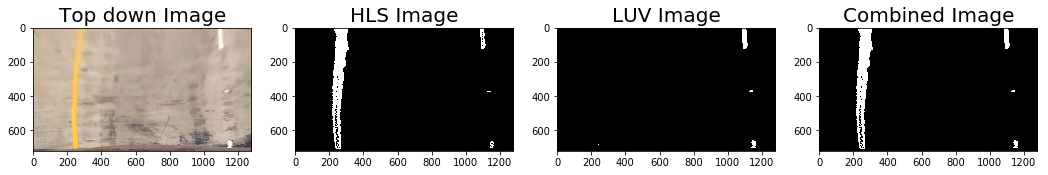

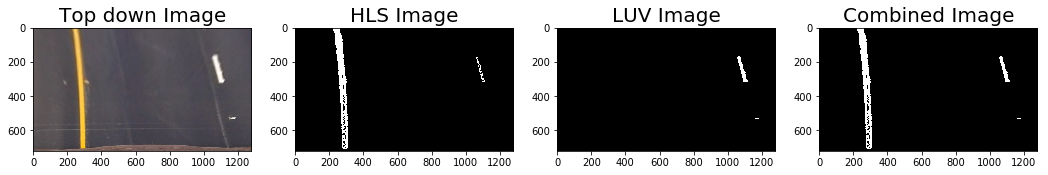

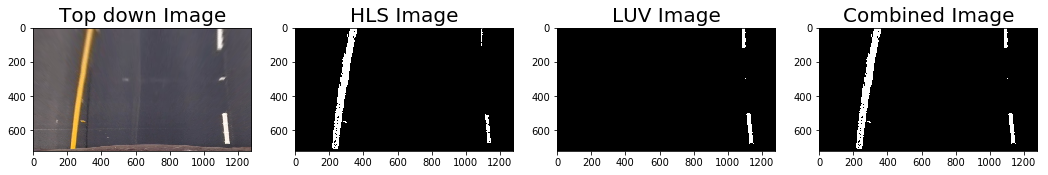

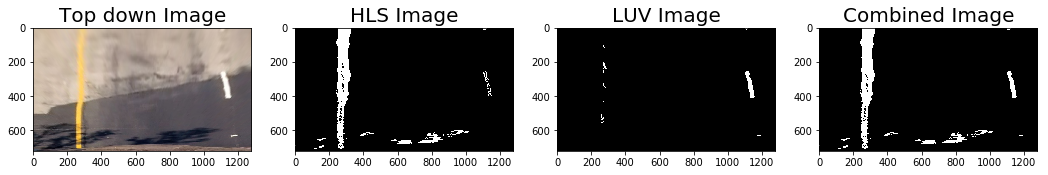

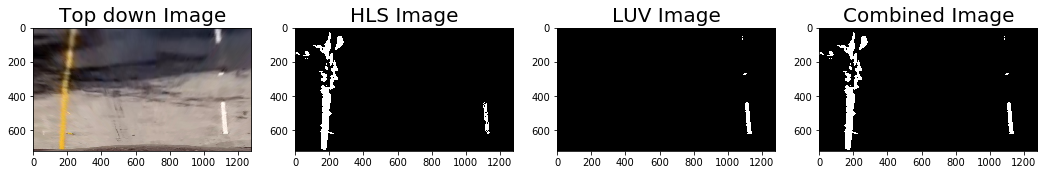

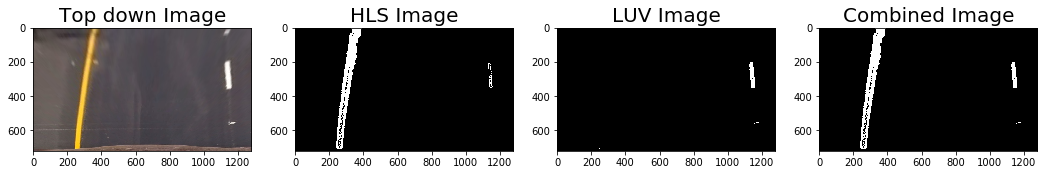

In [16]:
for image in images:
    img = mpimg.imread(image)
    undist_img = undistort(img, objpoints, imgpoints)
    
    top_down, perspective_M = image_warp(undist_img, src, dst)

    hls_binary = hls_select(top_down, thresh=(100, 255))
    luv_binary = luv_select(top_down, thresh=(220, 255))

    color_combined = np.zeros_like(luv_binary)*255
    color_combined[(hls_binary == 1) | (luv_binary == 1)] = 1
    
    # Plot the results
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 6))

    ax1.imshow(top_down)
    ax1.set_title('Top down Image', fontsize=20)
    ax2.imshow(hls_binary, cmap='gray')
    ax2.set_title('HLS Image', fontsize=20)
    ax3.imshow(luv_binary, cmap='gray')
    ax3.set_title('LUV Image', fontsize=20)
    ax4.imshow(color_combined, cmap='gray')
    ax4.set_title('Combined Image', fontsize=20)
    
    plt.show()

In [17]:
# Calculate directional gradient
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, abs_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    # Thresholding
    grad_binary[(scaled_sobel >= abs_thresh[0]) & (scaled_sobel <= abs_thresh[1])] = 1

    # Return the result
    return grad_binary

# Calculate gradient magnitude
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    # Return the result
    return mag_binary

# Calculate gradient direction
def dir_threshold(img, sobel_kernel=3, dir_thresh=(0, np.pi/2)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1
    
    # Return the result
    return dir_binary

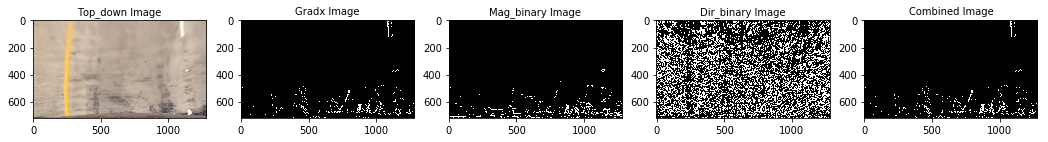

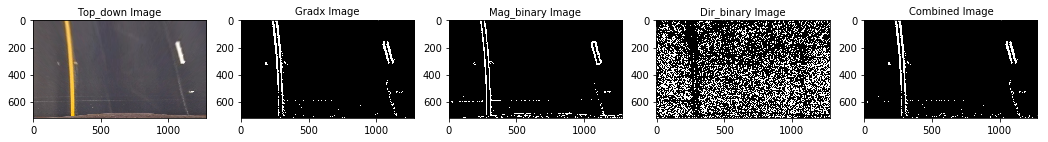

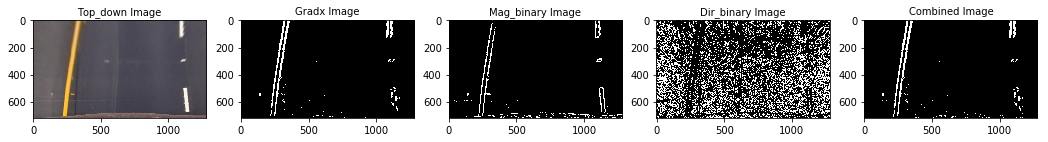

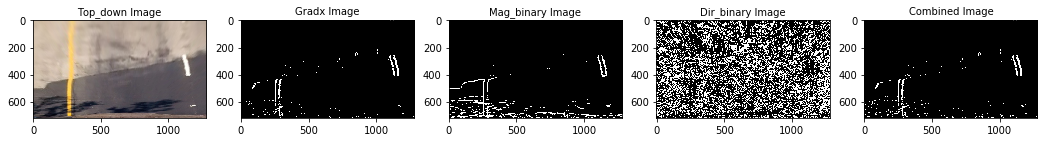

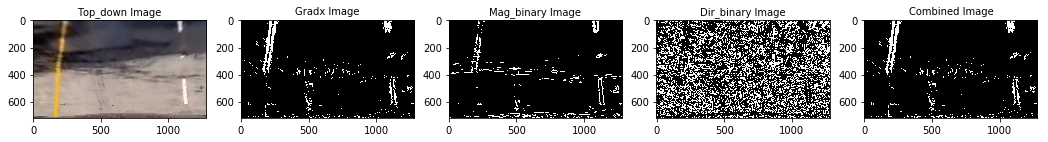

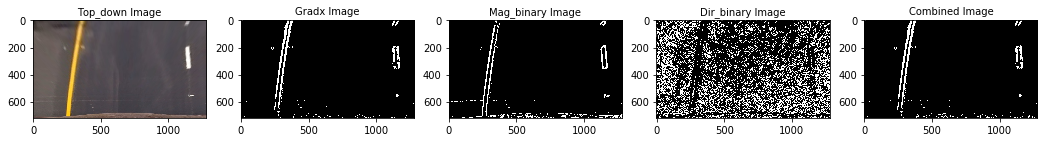

In [18]:
for image in images:
    img = mpimg.imread(image)
    undist_img = undistort(img, objpoints, imgpoints)
    
    top_down, perspective_M = image_warp(undist_img, src, dst)
    
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(top_down, orient='x', sobel_kernel=1, abs_thresh=(20, 120))
    grady = abs_sobel_thresh(top_down, orient='y', sobel_kernel=7, abs_thresh=(10, 120))
    mag_binary = mag_thresh(top_down, sobel_kernel=3, mag_thresh=(20, 120))
    dir_binary = dir_threshold(top_down, sobel_kernel=15, dir_thresh=(0.7, 1.3))

    combined = np.zeros_like(dir_binary)*255
    #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined[(gradx == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    # Plot the results
    f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(18, 6))

    ax1.imshow(top_down)
    ax1.set_title('Top_down Image', fontsize=10)
    ax2.imshow(gradx, cmap='gray')
    ax2.set_title('Gradx Image', fontsize=10)
    ax3.imshow(mag_binary, cmap='gray')
    ax3.set_title('Mag_binary Image', fontsize=10)
    ax4.imshow(dir_binary, cmap='gray')
    ax4.set_title('Dir_binary Image', fontsize=10)
    ax5.imshow(combined, cmap='gray')
    ax5.set_title('Combined Image', fontsize=10)
    
    plt.show()

    * Combine HLS and Gradient Thresholding

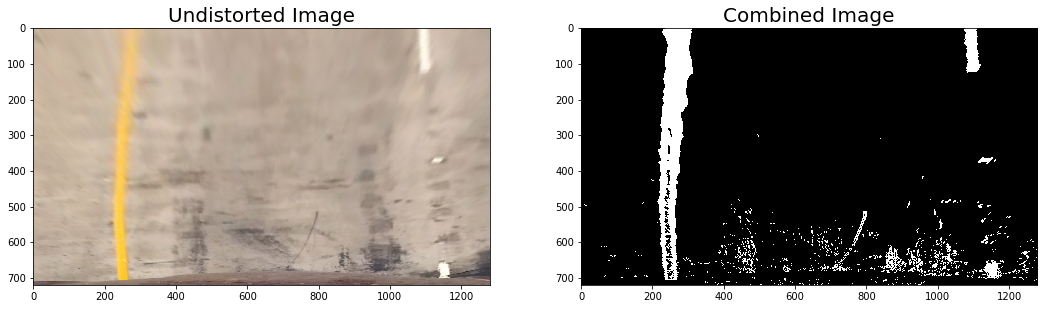

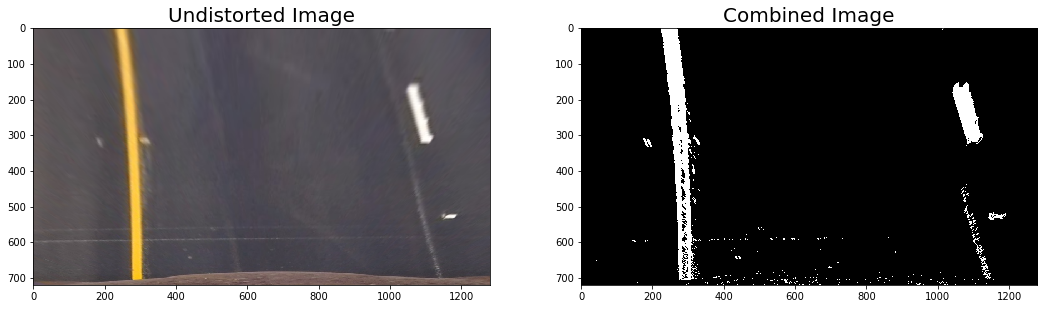

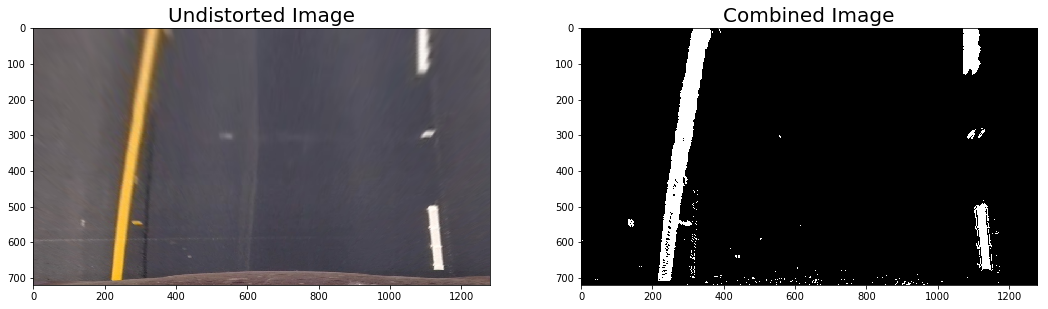

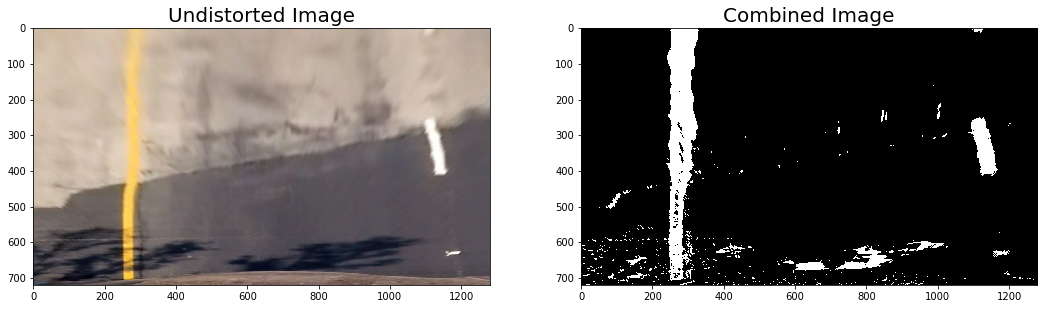

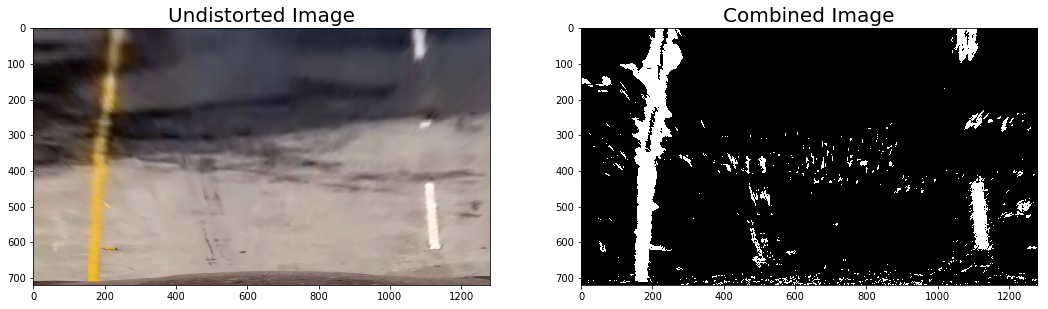

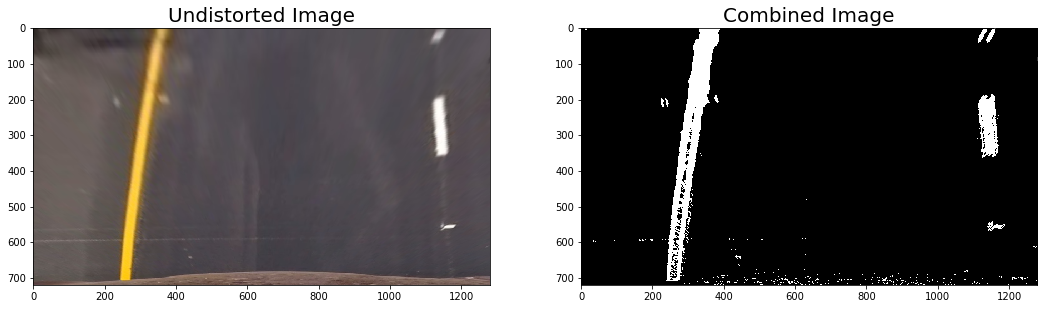

In [19]:
def combined_thresh(img):
    hls_binary = hls_select(top_down, thresh=(100, 255))
    luv_binary = luv_select(top_down, thresh=(220, 255))
    
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(top_down, orient='x', sobel_kernel=1, abs_thresh=(20, 120))
    grady = abs_sobel_thresh(top_down, orient='y', sobel_kernel=7, abs_thresh=(10, 120))
    mag_binary = mag_thresh(top_down, sobel_kernel=7, mag_thresh=(30, 100))
    dir_binary = dir_threshold(top_down, sobel_kernel=15, dir_thresh=(0.7, 1.3))

    combined = np.zeros_like(dir_binary)*255
    #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined[(hls_binary == 1 ) | (luv_binary == 1) | (gradx == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    #combined[(hls_binary == 1 ) | (luv_binary == 1)] = 1
    
    return combined

# Combine HLS and Gradient Thresholding
for image in images:
    img = mpimg.imread(image)
    undist_img = undistort(img, objpoints, imgpoints)
    
    top_down, perspective_M = image_warp(undist_img, src, dst)
    
    combined_img = combined_thresh(top_down)

    # Plot the results
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    ax1.imshow(top_down)
    ax1.set_title('Undistorted Image', fontsize=20)
    ax2.imshow(combined_img, cmap='gray')
    ax2.set_title('Combined Image', fontsize=20)
    
    plt.show()

## Step 5: Detect lane pixels and fit to find the lane boundary.

In [22]:
def hist(img):
    bottom_half = img[img.shape[0]//2:,:]
    #print (img.shape[0]//720)

    # Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    midpoint = np.int(histogram.shape[0]//2)
    leftx_peak = np.argmax(histogram[:midpoint])
    rightx_peak = np.argmax(histogram[midpoint:]) + midpoint
    print (leftx_peak, rightx_peak)
    
    return histogram

261 1149


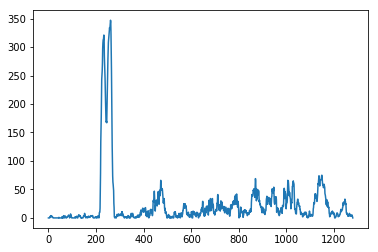

275 1130


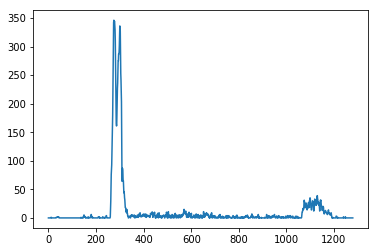

252 1127


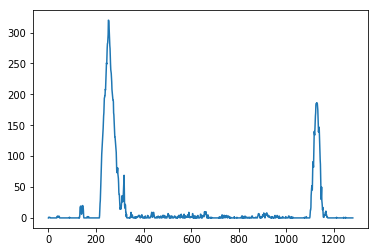

256 1154


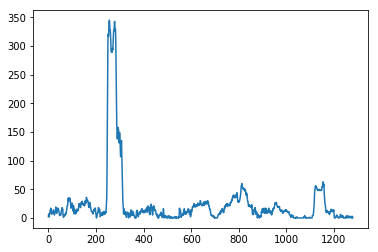

165 1119


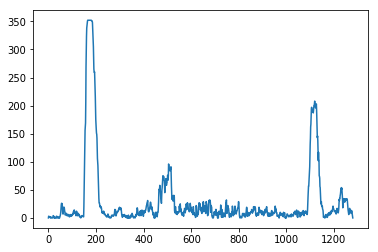

274 1152


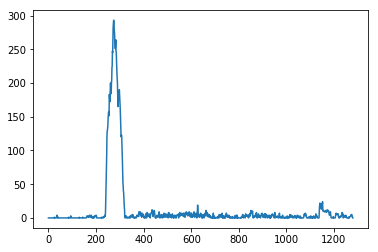

In [23]:
for image in images:
    img = mpimg.imread(image)
    undist_img = undistort(img, objpoints, imgpoints)
    
    top_down, perspective_M = image_warp(undist_img, src, dst)
    
    combined_img = combined_thresh(top_down)
    
    histogram = hist(combined_img)
    #print (histogram[230])
    
    # Plot the results
    plt.plot(histogram)
    plt.show()

In [43]:
def find_lane_pixels(binary_img):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_img[binary_img.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_img, binary_img, binary_img))
    #out_img = binary_img
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    #print (leftx_base)
    #print (rightx_base)

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 8
    # Set the width of the windows +/- margin
    margin = 20
    # Set minimum number of pixels found to recenter window
    minpix = 1

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_img.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    #print (leftx_current)
    #print (rightx_current)
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_img.shape[0] - (window+1)*window_height
        win_y_high = binary_img.shape[0] - window*window_height
        # Find four boundaries of the window
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        #print (win_xleft_low, win_xleft_high, win_xright_low, win_xright_high)
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & \
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & \
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        #print (window)
        #print (good_left_inds)
        #print (good_right_inds)
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img
        
def fit_polynomial(binary_img):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_img)
    #print (leftx)
    #print (lefty)
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_img.shape[0]-1, binary_img.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    #out_img[lefty, leftx] = [255, 0, 0]
    #out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

    return left_fitx, right_fitx, ploty, out_img

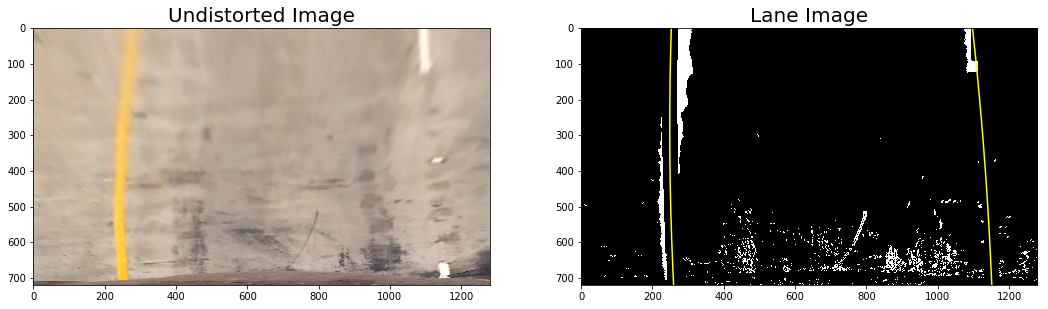

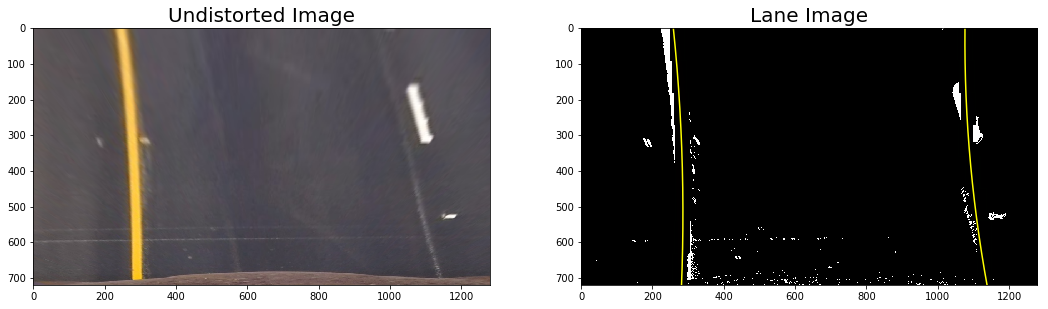

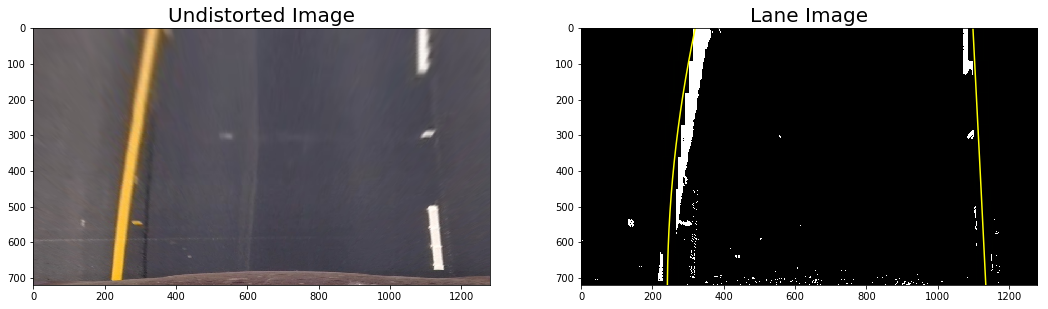

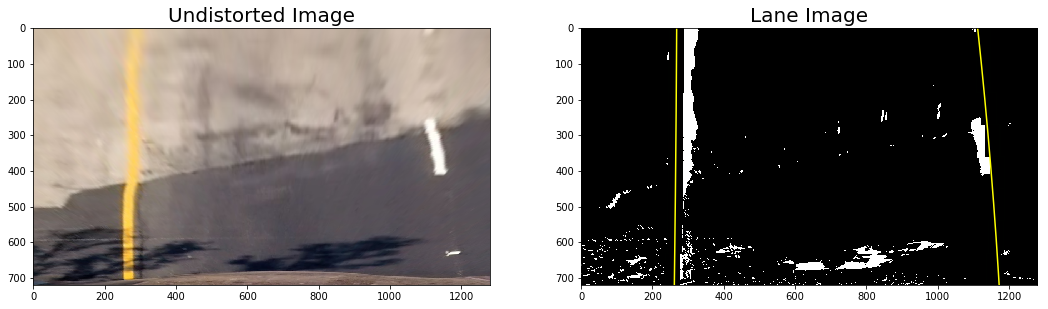

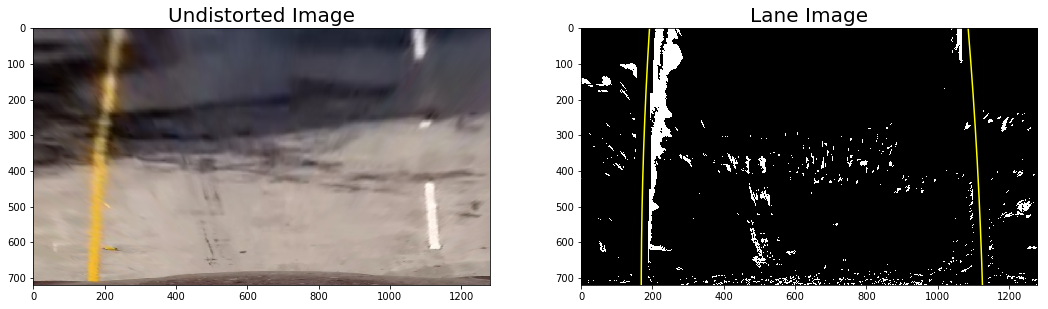

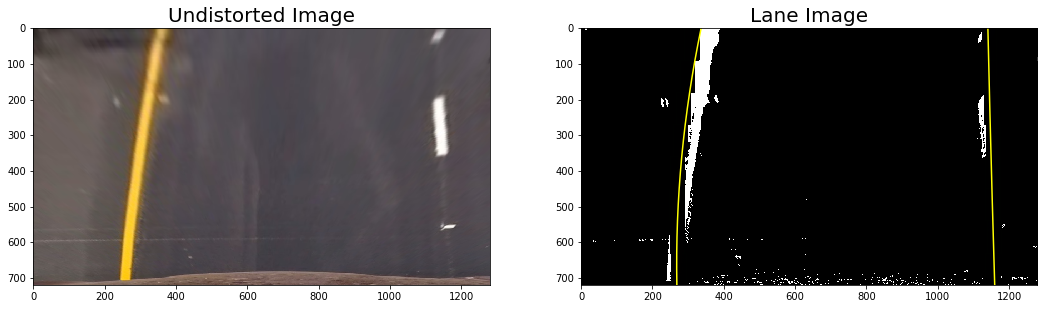

In [44]:
for image in images:
    img = mpimg.imread(image)
    undist_img = undistort(img, objpoints, imgpoints)
    
    top_down, perspective_M = image_warp(undist_img, src, dst)
    
    combined_img = combined_thresh(top_down)
    
    #leftx, lefty, rightx, righty, out_img = find_lane_pixels(combined_img)
    #out_img = fit_polynomial(combined_img)    
    left_fitx, right_fitx, ploty, out_img = fit_polynomial(combined_img)
    
    #print(leftx, lefty, rightx, righty)
    #print(left_fitx, right_fitx, ploty)
    
    # Plot the results
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    ax1.imshow(top_down)
    ax1.set_title('Undistorted Image', fontsize=20)
    ax2.imshow(out_img)
    ax2.set_title('Lane Image', fontsize=20)
    ax2.plot(left_fitx, ploty, color='yellow')
    ax2.plot(right_fitx, ploty, color='yellow')
    
    plt.show()